In [1]:
import numpy as np
import pandas as pd
import glob
import pandas_profiling
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns



/usr/local/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [13]:
# Read in data
df_list = [pd.read_csv(f, low_memory=False) for f in glob.glob('*.csv')]


In [14]:
# Make year list to make a column of each year in its respective dataframe
year_list = list(np.arange(1996,2018))
len(year_list)

22

In [15]:
# Make a year column 
for index, df in enumerate(df_list):
    df['year'] = year_list[index]

In [16]:
# Concatenate all the dataframes into one dataframe
df=pd.concat(df_list, ignore_index=True)

In [17]:
len(df)

154228

In [18]:
# Save as pickle
pd.to_pickle(df, 'big_ol_df.pkl')

In [53]:
# If you need to rerun everything, start here:
# df = pd.read_pickle('big_ol_df.pkl')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154228 entries, 0 to 154227
Columns: 1978 entries, UNITID to year
dtypes: float64(624), int64(7), object(1347)
memory usage: 2.3+ GB


In [21]:
df_regression = df.loc[:, ['TUITFTE', 'INEXPFTE', 'AVGFACSAL',  'PCTPELL']]

In [54]:
df_regression

,TUITFTE,INEXPFTE,AVGFACSAL,PCTPELL
0,4626.0,6841.0,6460.0,0.6933
1,7289.0,16681.0,9420.0,0.3381
2,11969.0,4662.0,3500.0,0.6506
3,7264.0,9590.0,8482.0,0.3176
4,7220.0,7581.0,6794.0,0.7251
5,10179.0,10197.0,8822.0,0.2294
6,1679.0,5143.0,5498.0,0.6150
7,4356.0,5685.0,7333.0,0.3839
8,5991.0,5428.0,6763.0,0.4100
9,11043.0,10823.0,8808.0,0.1767


In [24]:
# Observing how much of our data is na
df_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154228 entries, 0 to 154227
Data columns (total 4 columns):
TUITFTE      133780 non-null float64
INEXPFTE     133775 non-null float64
AVGFACSAL    88298 non-null float64
PCTPELL      67384 non-null float64
dtypes: float64(4)
memory usage: 4.7 MB


In [25]:
# Dropping na values for regression (still have ~80k data points and we just want to practice ridge regression)
df_no_na = df_regression.dropna()

In [27]:
# Renaming columns
df_no_na.columns = ['tuition', 'instructional_exp', 'fac_salary', 'pct_pell']

In [28]:
# Getting rid of zeros for regression
df_no_na.replace(0, 0.01, inplace=True)

In [55]:
df_no_na

,tuition,instructional_exp,fac_salary,pct_pell
0,4626.00,6841.00,6460.0,0.6933
1,7289.00,16681.00,9420.0,0.3381
2,11969.00,4662.00,3500.0,0.6506
3,7264.00,9590.00,8482.0,0.3176
4,7220.00,7581.00,6794.0,0.7251
5,10179.00,10197.00,8822.0,0.2294
6,1679.00,5143.00,5498.0,0.6150
7,4356.00,5685.00,7333.0,0.3839
8,5991.00,5428.00,6763.0,0.4100
9,11043.00,10823.00,8808.0,0.1767


In [58]:
# Performing the regression

from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# Create dataframes( or series) with predictors and  predicted values
# 'instructional_exp', 'fac_salary', 'pct_pell', 'tuition'
X = df_no_na[['tuition']]
y = df_no_na['instructional_exp']
    
# Scale the data using Robust Scaler
scale = PowerTransformer(method='box-cox', standardize=False)
transformed = scale.fit_transform(X)
X = pd.DataFrame(transformed, columns = X.columns)

# Create Train and Test Data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Create a ridge regression model
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)

# Create predicted values
y_h_ridge_train = ridge.predict(X_train)
y_h_ridge_test = ridge.predict(X_test)

In [60]:
ridge.score(X_train, y_train)

0.06165719875132325

In [61]:
ridge.coef_

array([46.88230466])

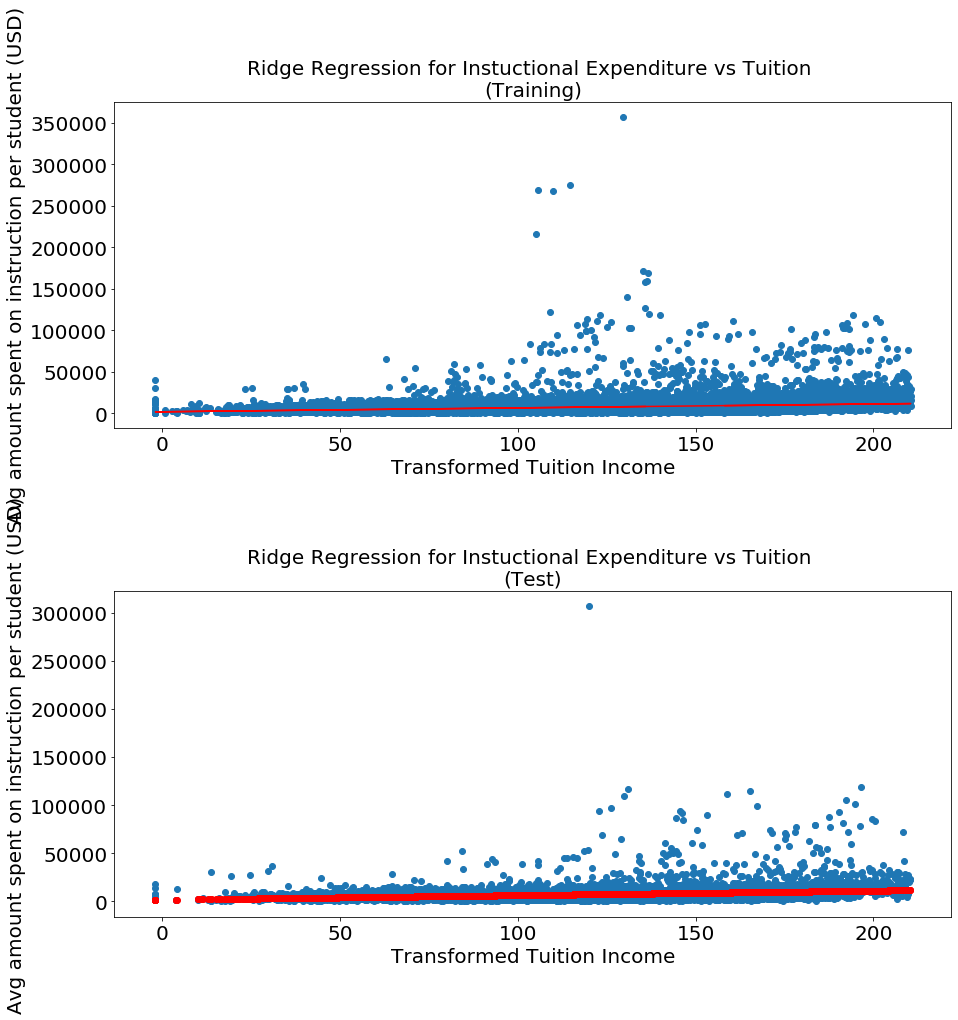

In [63]:
fig = plt.figure(figsize=(15,15))


# Plotting the training data + predicitons
ax1 = fig.add_subplot(211)
plt.title('Ridge Regression for Instuctional Expenditure vs Tuition \n(Training)', fontsize=20)
# plt.text(5.5,30000,f'$R^2 = {round(ridge.score(X_train,y_train), 2)}$', fontsize=20)
plt.xlabel('Transformed Tuition Income', fontsize = 20 )
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Avg amount spent on instruction per student (USD)', fontsize=20)
plt.scatter(X_train, y_train)
plt.plot(X_train, y_h_ridge_train, color='red')


# Plotting the testing data + predicitons
ax2 = fig.add_subplot(212, sharex=ax1)
plt.title('Ridge Regression for Instuctional Expenditure vs Tuition \n(Test)', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.text(5.5,15000,f'$R^2 = {round(ridge.score(X_test,y_test), 2)}$', fontsize=20)
plt.xlabel('Transformed Tuition Income', fontsize = 20 )
plt.ylabel('Avg amount spent on instruction per student (USD)', fontsize=20)
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_h_ridge_test, color='red')


plt.subplots_adjust(hspace=0.5)
plt.savefig('instruction_vs_tuition.png')




In [ ]:
# There are a lot of outliers... Trying 99th percentile...


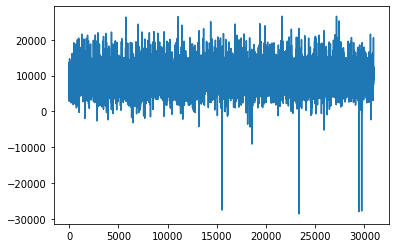

In [46]:
plt.plot(np.arange(0,len(y_h_ridge_train)), y_h_ridge_train)